In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Jokes WO Pairs**
Subset: 4000+4000

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

# Load the new dataset
file_path = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/jokeswopairs.csv'
new_data = pd.read_csv(file_path)

# Step 1: Create a Balanced Dataset
nsfw_subset = new_data[new_data['Classification'] == 'NSFW'].sample(n=4000, random_state=42)
sfw_subset = new_data[new_data['Classification'] == 'SFW'].sample(n=4000, random_state=42)

# Combine and shuffle the subsets
balanced_data = pd.concat([nsfw_subset, sfw_subset]).sample(frac=1, random_state=42)

# Verify the class distribution
print(balanced_data['Classification'].value_counts())

# Step 2: Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_data['Joke'].tolist(),
    balanced_data['Classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist(),
    test_size=0.2,
    random_state=42
)

# Step 3: Tokenize the Data
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 4: Prepare Dataset Class
class JokesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JokesDataset(train_encodings, train_labels)
test_dataset = JokesDataset(test_encodings, test_labels)

# Step 5: Load Pre-Trained DistilBERT Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Step 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results_distilbert',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_distilbert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",  # Disable integrations like W&B
)

# Step 7: Define Compute Metrics Function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Step 9: Train the Model
trainer.train()

# Step 10: Evaluate the Model
results = trainer.evaluate()

# Print Evaluation Results
def print_evaluation_results(results):
    print("Evaluation Results:")
    print(f"- Loss: {results['eval_loss']:.4f}")
    print(f"- Accuracy: {results['eval_accuracy']:.2%}")
    print(f"- Precision: {results['eval_precision']:.2%}")
    print(f"- Recall: {results['eval_recall']:.2%}")
    print(f"- F1 Score: {results['eval_f1']:.2%}")
    print(f"- Evaluation Runtime: {results['eval_runtime']:.2f} seconds")
    print(f"- Samples per Second: {results['eval_samples_per_second']:.2f}")
    print(f"- Steps per Second: {results['eval_steps_per_second']:.2f}")

print_evaluation_results(results)


Classification
NSFW    4000
SFW     4000
Name: count, dtype: int64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-10-42105bdae696>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.446300,0.380355,0.843125,0.836810,0.852500,0.844582
2,0.175800,0.461815,0.832500,0.854667,0.801250,0.827097
3,0.132000,0.693445,0.841875,0.851995,0.827500,0.839569


<ipython-input-10-42105bdae696>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-42105bdae696>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-42105bdae696>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-42105bdae696>:45: UserWarning: To copy construct fro

Evaluation Results:
- Loss: 0.3804
- Accuracy: 84.31%
- Precision: 83.68%
- Recall: 85.25%
- F1 Score: 84.46%
- Evaluation Runtime: 3.60 seconds
- Samples per Second: 444.39
- Steps per Second: 27.77


In [ ]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

# Load the new dataset
file_path = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/jokeswopairs.csv'
new_data = pd.read_csv(file_path)

# Step 1: Create a Balanced Dataset
nsfw_subset = new_data[new_data['Classification'] == 'NSFW'].sample(n=3000, random_state=42)
sfw_subset = new_data[new_data['Classification'] == 'SFW'].sample(n=3000, random_state=42)

# Combine and shuffle the subsets
balanced_data = pd.concat([nsfw_subset, sfw_subset]).sample(frac=1, random_state=42)

# Verify the class distribution
print(balanced_data['Classification'].value_counts())

# Step 2: Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_data['Joke'].tolist(),
    balanced_data['Classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist(),
    test_size=0.2,
    random_state=42
)

# Step 3: Tokenize the Data
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 4: Prepare Dataset Class
class JokesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JokesDataset(train_encodings, train_labels)
test_dataset = JokesDataset(test_encodings, test_labels)

# Step 5: Load Pre-Trained DistilBERT Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Step 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results_distilbert',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_distilbert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",  # Disable integrations like W&B
)

# Step 7: Define Compute Metrics Function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Step 9: Train the Model
trainer.train()

# Step 10: Evaluate the Model
results = trainer.evaluate()

# Print Evaluation Results
def print_evaluation_results(results):
    print("Evaluation Results:")
    print(f"- Loss: {results['eval_loss']:.4f}")
    print(f"- Accuracy: {results['eval_accuracy']:.2%}")
    print(f"- Precision: {results['eval_precision']:.2%}")
    print(f"- Recall: {results['eval_recall']:.2%}")
    print(f"- F1 Score: {results['eval_f1']:.2%}")
    print(f"- Evaluation Runtime: {results['eval_runtime']:.2f} seconds")
    print(f"- Samples per Second: {results['eval_samples_per_second']:.2f}")
    print(f"- Steps per Second: {results['eval_steps_per_second']:.2f}")

print_evaluation_results(results)


Classification
NSFW    3000
SFW     3000
Name: count, dtype: int64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-30ad70d6349d>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.437200,0.495988,0.763333,0.716535,0.889251,0.793605
2,0.194900,0.650318,0.805000,0.790520,0.842020,0.815457
3,0.066000,0.799032,0.809167,0.830189,0.788274,0.808688


<ipython-input-11-30ad70d6349d>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-30ad70d6349d>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-30ad70d6349d>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-30ad70d6349d>:45: UserWarning: To copy construct fro

Evaluation Results:
- Loss: 0.7990
- Accuracy: 80.92%
- Precision: 83.02%
- Recall: 78.83%
- F1 Score: 80.87%
- Evaluation Runtime: 2.22 seconds
- Samples per Second: 539.66
- Steps per Second: 33.73


In [ ]:
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Load the new dataset
file_path = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/jokeswopairs.csv'
new_data = pd.read_csv(file_path)

# Step 1: Create a Balanced Dataset
nsfw_subset = new_data[new_data['Classification'] == 'NSFW'].sample(n=3000, random_state=42)
sfw_subset = new_data[new_data['Classification'] == 'SFW'].sample(n=3000, random_state=42)

# Combine and shuffle the subsets
balanced_data = pd.concat([nsfw_subset, sfw_subset]).sample(frac=1, random_state=42)

# Verify the class distribution
print(balanced_data['Classification'].value_counts())

# Step 2: Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_data['Joke'].tolist(),
    balanced_data['Classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist(),
    test_size=0.2,
    random_state=42
)

# Step 3: Tokenize the Data
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 4: Prepare Dataset Class
class JokesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JokesDataset(train_encodings, train_labels)
test_dataset = JokesDataset(test_encodings, test_labels)

# Step 5: Load Pre-Trained RoBERTa Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Step 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results_roberta',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",  # Disable integrations like W&B
)

# Step 7: Define Compute Metrics Function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Step 9: Train the Model
trainer.train()

# Step 10: Evaluate the Model
results = trainer.evaluate()

# Print Evaluation Results
def print_evaluation_results(results):
    print("Evaluation Results:")
    print(f"- Loss: {results['eval_loss']:.4f}")
    print(f"- Accuracy: {results['eval_accuracy']:.2%}")
    print(f"- Precision: {results['eval_precision']:.2%}")
    print(f"- Recall: {results['eval_recall']:.2%}")
    print(f"- F1 Score: {results['eval_f1']:.2%}")
    print(f"- Evaluation Runtime: {results['eval_runtime']:.2f} seconds")
    print(f"- Samples per Second: {results['eval_samples_per_second']:.2f}")
    print(f"- Steps per Second: {results['eval_steps_per_second']:.2f}")

print_evaluation_results(results)


Classification
NSFW    3000
SFW     3000
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-f1a712065ac8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.543300,0.627728,0.710833,0.663804,0.881107,0.757173
2,0.417300,0.505800,0.752500,0.756888,0.760586,0.758733
3,0.243800,0.676959,0.753333,0.774138,0.731270,0.752094


<ipython-input-12-f1a712065ac8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-12-f1a712065ac8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-12-f1a712065ac8>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-12-f1a712065ac8>:44: UserWarning: To copy construct fro

Evaluation Results:
- Loss: 0.6770
- Accuracy: 75.33%
- Precision: 77.41%
- Recall: 73.13%
- F1 Score: 75.21%
- Evaluation Runtime: 3.91 seconds
- Samples per Second: 306.86
- Steps per Second: 19.18


**WITH PAIRS**

In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/jokes_10000.csv'
jokes_data = pd.read_csv(file_path)

# Randomly select 4000 NSFW jokes and their corresponding SFW pairs
nsfw_subset = jokes_data[jokes_data['Classification'] == 'NSFW'].sample(n=3000, random_state=42)
sfw_subset = jokes_data[jokes_data['Classification'] == 'SFW'].sample(n=3000, random_state=42)

# Combine the pairs into a single dataset and shuffle
joke_pairs_subset = pd.concat([nsfw_subset, sfw_subset]).sample(frac=1, random_state=42)

# Verify the structure of the subset
joke_pairs_subset_info = joke_pairs_subset.info()
joke_pairs_subset_head = joke_pairs_subset.head()

joke_pairs_subset_info, joke_pairs_subset_head



<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 32 to 4800
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Joke                6000 non-null   object
 1   Classification      6000 non-null   object
 2   New Classification  6000 non-null   object
 3   Opposite Joke       5867 non-null   object
dtypes: object(4)
memory usage: 234.4+ KB


(None,
                                                    Joke Classification  \
 32    How do Putin opponents commit suicide? Two bul...           NSFW   
 8591  What's the difference between a turkey sandwic...            SFW   
 5774  New body image study shows women with large br...           NSFW   
 5954  I like my women the same way I like my coffee....           NSFW   
 9193  What does the GRC on the Mounties cars stand f...            SFW   
 
      New Classification                                      Opposite Joke  
 32                  SFW  How do opponents in sports handle defeat? By l...  
 8591               NSFW  What’s the difference between a turkey sandwic...  
 5774                SFW  Women with strong confidence are generally mor...  
 5954                SFW  I like my coffee exactly how it is—bold and warm.  
 9193               NSFW  What does GRC on Mounties’ cars stand for? Gra...  )

**DistilBERT: Testing on RANDOM Unseen Data:**

In [13]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import pandas as pd

# Step 1: Load and Balance the Training Dataset
file_path_train = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/jokes_10000.csv'  # Train data path
train_data = pd.read_csv(file_path_train)

# Balance the dataset: 3000 NSFW and 3000 SFW jokes
nsfw_subset = train_data[train_data['Classification'] == 'NSFW'].sample(n=3000, random_state=42)
sfw_subset = train_data[train_data['Classification'] == 'SFW'].sample(n=3000, random_state=42)
balanced_data = pd.concat([nsfw_subset, sfw_subset]).sample(frac=1, random_state=42)

# Step 2: Split into Training and Testing Sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_data['Joke'].tolist(),
    balanced_data['Classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist(),
    test_size=0.2,
    random_state=42
)

# Step 3: Tokenize the Data
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 4: Prepare Dataset Class
class JokesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JokesDataset(train_encodings, train_labels)
test_dataset = JokesDataset(test_encodings, test_labels)

# Step 5: Load Pre-Trained DistilBERT Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Step 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results_distilbert',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_distilbert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",
)

# Step 7: Define Compute Metrics Function
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Step 9: Train the Model
trainer.train()

# Step 10: Load the External Dataset for Evaluation
file_path_test = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/random_10000_jokes.csv'  # Test data path
test_data = pd.read_csv(file_path_test)

# Take 20% of the external dataset (6000 samples = 1200 for 20%)
test_subset = test_data.sample(n=1200, random_state=42)

# Prepare the test set
external_texts = test_subset['jokes'].tolist()
external_labels = test_subset['classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist()

# Tokenize the external test data
external_encodings = tokenizer(external_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Prepare the external test dataset
external_test_dataset = JokesDataset(external_encodings, external_labels)

# Step 11: Evaluate the Model on External Test Set
results_external = trainer.evaluate(eval_dataset=external_test_dataset)

# Step 12: Print Evaluation Results
def print_evaluation_results(results):
    print("Evaluation Results:")
    print(f"- Loss: {results['eval_loss']:.4f}")
    print(f"- Accuracy: {results['eval_accuracy']:.2%}")
    print(f"- Precision: {results['eval_precision']:.2%}")
    print(f"- Recall: {results['eval_recall']:.2%}")
    print(f"- F1 Score: {results['eval_f1']:.2%}")
    print(f"- Evaluation Runtime: {results['eval_runtime']:.2f} seconds")
    print(f"- Samples per Second: {results['eval_samples_per_second']:.2f}")
    print(f"- Steps per Second: {results['eval_steps_per_second']:.2f}")

print_evaluation_results(results_external)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-13-fbb806aba3fe>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.473500,0.483691,0.766667,0.720317,0.889251,0.795918
2,0.236300,0.597103,0.813333,0.815534,0.820847,0.818182
3,0.046600,0.801588,0.810833,0.823038,0.802932,0.812861


<ipython-input-13-fbb806aba3fe>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-13-fbb806aba3fe>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-13-fbb806aba3fe>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-13-fbb806aba3fe>:39: UserWarning: To copy construct fro

Evaluation Results:
- Loss: 0.3898
- Accuracy: 86.83%
- Precision: 93.15%
- Recall: 85.58%
- F1 Score: 89.21%
- Evaluation Runtime: 4.76 seconds
- Samples per Second: 252.12
- Steps per Second: 15.76


In [19]:
#UNIQUE Test balanced
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import pandas as pd

# Step 1: Load and Balance the Training Dataset
file_path_train = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/jokes_10000.csv'  # Train data path
train_data = pd.read_csv(file_path_train)

# Balance the dataset: 3000 NSFW and 3000 SFW jokes
nsfw_subset = train_data[train_data['Classification'] == 'NSFW'].sample(n=3000, random_state=42)
sfw_subset = train_data[train_data['Classification'] == 'SFW'].sample(n=3000, random_state=42)
balanced_data = pd.concat([nsfw_subset, sfw_subset]).sample(frac=1, random_state=42)

# Extract all jokes used in training
train_jokes = set(balanced_data['Joke'])

# Step 2: Split Training Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_data['Joke'].tolist(),
    balanced_data['Classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist(),
    test_size=0.2,
    random_state=42
)

# Step 3: Tokenize the Data
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 4: Prepare Dataset Class
class JokesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JokesDataset(train_encodings, train_labels)
test_dataset = JokesDataset(test_encodings, test_labels)

# Step 5: Load Pre-Trained DistilBERT Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Step 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results_distilbert',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_distilbert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",
)

# Step 7: Define Compute Metrics Function
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Step 9: Train the Model
trainer.train()

# Step 10: Load and Filter the External Test Dataset
file_path_test = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/random_10000_jokes.csv'  # Test data path
test_data = pd.read_csv(file_path_test)

# Ensure the test set contains unique jokes not in the training set
unique_test_data = test_data[~test_data['jokes'].isin(train_jokes)]

# Separate `NSFW` and `SFW` for balancing
nsfw_subset_test = unique_test_data[unique_test_data['classification'] == 'NSFW'].sample(n=600, random_state=42)
sfw_subset_test = unique_test_data[unique_test_data['classification'] == 'SFW'].sample(n=600, random_state=42)

# Combine and shuffle the balanced test set
balanced_test_subset = pd.concat([nsfw_subset_test, sfw_subset_test]).sample(frac=1, random_state=42)

# Prepare the balanced test set
external_texts = balanced_test_subset['jokes'].tolist()
external_labels = balanced_test_subset['classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist()

# Tokenize the balanced test data
external_encodings = tokenizer(external_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Prepare the external test dataset
external_test_dataset = JokesDataset(external_encodings, external_labels)

# Step 11: Evaluate the Model on Balanced Test Set
results_external = trainer.evaluate(eval_dataset=external_test_dataset)

# Step 12: Print Evaluation Results
def print_evaluation_results(results):
    print("Evaluation Results:")
    print(f"- Loss: {results['eval_loss']:.4f}")
    print(f"- Accuracy: {results['eval_accuracy']:.2%}")
    print(f"- Precision: {results['eval_precision']:.2%}")
    print(f"- Recall: {results['eval_recall']:.2%}")
    print(f"- F1 Score: {results['eval_f1']:.2%}")
    print(f"- Evaluation Runtime: {results['eval_runtime']:.2f} seconds")
    print(f"- Samples per Second: {results['eval_samples_per_second']:.2f}")
    print(f"- Steps per Second: {results['eval_steps_per_second']:.2f}")

print_evaluation_results(results_external)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-d26ec5c3ed38>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.437200,0.495988,0.763333,0.716535,0.889251,0.793605
2,0.194900,0.650318,0.805000,0.790520,0.842020,0.815457
3,0.066000,0.799032,0.809167,0.830189,0.788274,0.808688


<ipython-input-19-d26ec5c3ed38>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-d26ec5c3ed38>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-d26ec5c3ed38>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-d26ec5c3ed38>:43: UserWarning: To copy construct fro

Evaluation Results:
- Loss: 0.7543
- Accuracy: 83.08%
- Precision: 83.70%
- Recall: 82.17%
- F1 Score: 82.93%
- Evaluation Runtime: 4.58 seconds
- Samples per Second: 262.15
- Steps per Second: 16.38


In [17]:
#UNIQUE TEST RoBERTa IMBALANCED
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import pandas as pd

# Step 1: Load and Balance the Training Dataset
file_path_train = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/jokes_10000.csv'  # Train data path
train_data = pd.read_csv(file_path_train)

# Balance the dataset: 3000 NSFW and 3000 SFW jokes
nsfw_subset = train_data[train_data['Classification'] == 'NSFW'].sample(n=3000, random_state=42)
sfw_subset = train_data[train_data['Classification'] == 'SFW'].sample(n=3000, random_state=42)
balanced_data = pd.concat([nsfw_subset, sfw_subset]).sample(frac=1, random_state=42)

# Extract all jokes used in training
train_jokes = set(balanced_data['Joke'])

# Step 2: Split Training Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_data['Joke'].tolist(),
    balanced_data['Classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist(),
    test_size=0.2,
    random_state=42
)

# Step 3: Tokenize the Data
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 4: Prepare Dataset Class
class JokesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JokesDataset(train_encodings, train_labels)
test_dataset = JokesDataset(test_encodings, test_labels)

# Step 5: Load Pre-Trained RoBERTa Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Step 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results_roberta',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",
)

# Step 7: Define Compute Metrics Function
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Step 9: Train the Model
trainer.train()

# Step 10: Load and Filter the External Test Dataset
file_path_test = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/random_10000_jokes.csv'  # Test data path
test_data = pd.read_csv(file_path_test)

# Ensure the test set contains unique jokes not in the training set
unique_test_data = test_data[~test_data['jokes'].isin(train_jokes)]

# Take 1200 unique jokes for testing
test_subset = unique_test_data.sample(n=1200, random_state=42)

# Prepare the test set
external_texts = test_subset['jokes'].tolist()
external_labels = test_subset['classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist()

# Tokenize the external test data
external_encodings = tokenizer(external_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Prepare the external test dataset
external_test_dataset = JokesDataset(external_encodings, external_labels)

# Step 11: Evaluate the Model on External Test Set
results_external = trainer.evaluate(eval_dataset=external_test_dataset)

# Step 12: Print Evaluation Results
def print_evaluation_results(results):
    print("Evaluation Results:")
    print(f"- Loss: {results['eval_loss']:.4f}")
    print(f"- Accuracy: {results['eval_accuracy']:.2%}")
    print(f"- Precision: {results['eval_precision']:.2%}")
    print(f"- Recall: {results['eval_recall']:.2%}")
    print(f"- F1 Score: {results['eval_f1']:.2%}")
    print(f"- Evaluation Runtime: {results['eval_runtime']:.2f} seconds")
    print(f"- Samples per Second: {results['eval_samples_per_second']:.2f}")
    print(f"- Steps per Second: {results['eval_steps_per_second']:.2f}")

print_evaluation_results(results_external)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-df92dfb8abd4>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.543300,0.627728,0.710833,0.663804,0.881107,0.757173
2,0.417300,0.505800,0.752500,0.756888,0.760586,0.758733
3,0.243800,0.676959,0.753333,0.774138,0.731270,0.752094


<ipython-input-17-df92dfb8abd4>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-17-df92dfb8abd4>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-17-df92dfb8abd4>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-17-df92dfb8abd4>:43: UserWarning: To copy construct fro

Evaluation Results:
- Loss: 0.6246
- Accuracy: 76.75%
- Precision: 89.39%
- Recall: 76.57%
- F1 Score: 82.49%
- Evaluation Runtime: 8.36 seconds
- Samples per Second: 143.49
- Steps per Second: 8.97


In [20]:
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import pandas as pd

# Step 1: Load and Balance the Training Dataset
file_path_train = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/jokes_10000.csv'  # Train data path
train_data = pd.read_csv(file_path_train)

# Balance the dataset: 3000 NSFW and 3000 SFW jokes
nsfw_subset = train_data[train_data['Classification'] == 'NSFW'].sample(n=3000, random_state=42)
sfw_subset = train_data[train_data['Classification'] == 'SFW'].sample(n=3000, random_state=42)
balanced_data = pd.concat([nsfw_subset, sfw_subset]).sample(frac=1, random_state=42)

# Extract all jokes used in training
train_jokes = set(balanced_data['Joke'])

# Step 2: Split Training Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_data['Joke'].tolist(),
    balanced_data['Classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist(),
    test_size=0.2,
    random_state=42
)

# Step 3: Tokenize the Data
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 4: Prepare Dataset Class
class JokesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JokesDataset(train_encodings, train_labels)
test_dataset = JokesDataset(test_encodings, test_labels)

# Step 5: Load Pre-Trained RoBERTa Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Step 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results_roberta',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",
)

# Step 7: Define Compute Metrics Function
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Step 9: Train the Model
trainer.train()

# Step 10: Load and Filter the External Test Dataset
file_path_test = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/random_10000_jokes.csv'  # Test data path
test_data = pd.read_csv(file_path_test)

# Ensure the test set contains unique jokes not in the training set
unique_test_data = test_data[~test_data['jokes'].isin(train_jokes)]

# Separate `NSFW` and `SFW` for balancing
nsfw_subset_test = unique_test_data[unique_test_data['classification'] == 'NSFW'].sample(n=600, random_state=42)
sfw_subset_test = unique_test_data[unique_test_data['classification'] == 'SFW'].sample(n=600, random_state=42)

# Combine and shuffle the balanced test set
balanced_test_subset = pd.concat([nsfw_subset_test, sfw_subset_test]).sample(frac=1, random_state=42)

# Prepare the balanced test set
external_texts = balanced_test_subset['jokes'].tolist()
external_labels = balanced_test_subset['classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist()

# Tokenize the balanced test data
external_encodings = tokenizer(external_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Prepare the external test dataset
external_test_dataset = JokesDataset(external_encodings, external_labels)

# Step 11: Evaluate the Model on Balanced Test Set
results_external = trainer.evaluate(eval_dataset=external_test_dataset)

# Step 12: Print Evaluation Results
def print_evaluation_results(results):
    print("Evaluation Results:")
    print(f"- Loss: {results['eval_loss']:.4f}")
    print(f"- Accuracy: {results['eval_accuracy']:.2%}")
    print(f"- Precision: {results['eval_precision']:.2%}")
    print(f"- Recall: {results['eval_recall']:.2%}")
    print(f"- F1 Score: {results['eval_f1']:.2%}")
    print(f"- Evaluation Runtime: {results['eval_runtime']:.2f} seconds")
    print(f"- Samples per Second: {results['eval_samples_per_second']:.2f}")
    print(f"- Steps per Second: {results['eval_steps_per_second']:.2f}")

print_evaluation_results(results_external)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-7706e9ae5be7>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.543300,0.627728,0.710833,0.663804,0.881107,0.757173
2,0.417300,0.505800,0.752500,0.756888,0.760586,0.758733
3,0.243800,0.676959,0.753333,0.774138,0.731270,0.752094


<ipython-input-20-7706e9ae5be7>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-20-7706e9ae5be7>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-20-7706e9ae5be7>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-20-7706e9ae5be7>:42: UserWarning: To copy construct fro

Evaluation Results:
- Loss: 0.6101
- Accuracy: 78.67%
- Precision: 79.55%
- Recall: 77.17%
- F1 Score: 78.34%
- Evaluation Runtime: 8.56 seconds
- Samples per Second: 140.23
- Steps per Second: 8.76


In [4]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Ensure `joke_pairs_subset` is correctly structured
assert 'Joke' in joke_pairs_subset.columns, "Dataset must have a 'Joke' column."
assert 'Classification' in joke_pairs_subset.columns, "Dataset must have a 'Classification' column."

# Step 1: Prepare the Dataset for RoBERTa
# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    joke_pairs_subset['Joke'].tolist(),
    joke_pairs_subset['Classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist(),
    test_size=0.2,
    random_state=42
)

# Step 2: Tokenize the Data
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 3: Prepare Dataset Class
class JokesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JokesDataset(train_encodings, train_labels)
test_dataset = JokesDataset(test_encodings, test_labels)

# Debug Labels
train_labels = [int(label) for label in train_labels]
test_labels = [int(label) for label in test_labels]

# Step 4: Load Pre-Trained RoBERTa Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Update Training Arguments
training_args = TrainingArguments(
    output_dir='./results_roberta',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Reduced batch size
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",
)

# Step 6: Define Compute Metrics Function
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Reinitialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the Model
trainer.train()

# Step 9: Evaluate the Model
results = trainer.evaluate()

# Print Evaluation Results
def print_evaluation_results(results):
    print("Evaluation Results:")
    print(f"- Loss: {results['eval_loss']:.4f}")
    print(f"- Accuracy: {results['eval_accuracy']:.2%}")
    print(f"- Precision: {results['eval_precision']:.2%}")
    print(f"- Recall: {results['eval_recall']:.2%}")
    print(f"- F1 Score: {results['eval_f1']:.2%}")
    print(f"- Evaluation Runtime: {results['eval_runtime']:.2f} seconds")
    print(f"- Samples per Second: {results['eval_samples_per_second']:.2f}")
    print(f"- Steps per Second: {results['eval_steps_per_second']:.2f}")

print_evaluation_results(results)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-c962799ca704>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.648200,0.596865,0.685000,0.843023,0.472313,0.605428
2,0.444800,0.566158,0.710000,0.832500,0.542345,0.656805
3,0.423000,0.583306,0.760833,0.760766,0.776873,0.768735


<ipython-input-4-c962799ca704>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-4-c962799ca704>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-4-c962799ca704>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-4-c962799ca704>:31: UserWarning: To copy construct from a 

Evaluation Results:
- Loss: 0.5833
- Accuracy: 76.08%
- Precision: 76.08%
- Recall: 77.69%
- F1 Score: 76.87%
- Evaluation Runtime: 4.09 seconds
- Samples per Second: 293.53
- Steps per Second: 36.69


**GPT Jokes**

In [6]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import pandas as pd

# Step 1: Load the Dataset
file_path = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/chatgptfromscratch.csv'  # Replace with your file path
jokes_data = pd.read_csv(file_path)

# Step 2: Create a Balanced Subset
nsfw_subset = jokes_data[jokes_data['Classification'] == 'NSFW'].sample(n=3000, random_state=42)
sfw_subset = jokes_data[jokes_data['Classification'] == 'SFW'].sample(n=3000, random_state=42)

# Combine and shuffle the subsets
balanced_data = pd.concat([nsfw_subset, sfw_subset]).sample(frac=1, random_state=42)

# Verify the class distribution
print(balanced_data['Classification'].value_counts())

# Step 3: Split Data into Train and Test Sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_data['Jokes'].tolist(),
    balanced_data['Classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist(),
    test_size=0.2,
    random_state=42
)

# Step 4: Tokenize the Data
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 5: Prepare Dataset Class
class JokesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JokesDataset(train_encodings, train_labels)
test_dataset = JokesDataset(test_encodings, test_labels)

# Step 6: Load Pre-Trained BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Step 7: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results_bert',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_bert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",
)

# Step 8: Define Compute Metrics Function
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Step 9: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Step 10: Train the Model
trainer.train()

# Step 11: Evaluate the Model
results = trainer.evaluate()

# Step 12: Print Evaluation Results
def print_evaluation_results(results):
    print("Evaluation Results:")
    print(f"- Loss: {results['eval_loss']:.4f}")
    print(f"- Accuracy: {results['eval_accuracy']:.2%}")
    print(f"- Precision: {results['eval_precision']:.2%}")
    print(f"- Recall: {results['eval_recall']:.2%}")
    print(f"- F1 Score: {results['eval_f1']:.2%}")
    print(f"- Evaluation Runtime: {results['eval_runtime']:.2f} seconds")
    print(f"- Samples per Second: {results['eval_samples_per_second']:.2f}")
    print(f"- Steps per Second: {results['eval_steps_per_second']:.2f}")

print_evaluation_results(results)


Classification
NSFW    3000
SFW     3000
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-6ddea3aba3b1>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.043900,0.021997,0.990833,0.996705,0.985342,0.990991
2,0.000200,0.012674,0.997500,0.996748,0.998371,0.997559
3,0.000100,0.014182,0.998333,0.996753,1.000000,0.998374


<ipython-input-6-6ddea3aba3b1>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-6-6ddea3aba3b1>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-6-6ddea3aba3b1>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-6-6ddea3aba3b1>:44: UserWarning: To copy construct from a 

Evaluation Results:
- Loss: 0.0142
- Accuracy: 99.83%
- Precision: 99.68%
- Recall: 100.00%
- F1 Score: 99.84%
- Evaluation Runtime: 2.98 seconds
- Samples per Second: 403.02
- Steps per Second: 25.19


In [9]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import pandas as pd

# Step 1: Load the Training Dataset
file_path_train = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/chatgptfromscratch.csv'
train_data = pd.read_csv(file_path_train)

# Balance the dataset: 3000 NSFW and 3000 SFW jokes
nsfw_subset = train_data[train_data['Classification'] == 'NSFW'].sample(n=5000, random_state=42)
sfw_subset = train_data[train_data['Classification'] == 'SFW'].sample(n=5000, random_state=42)

# Combine and shuffle the subsets
balanced_train_data = pd.concat([nsfw_subset, sfw_subset]).sample(frac=1, random_state=42)

# Verify the class distribution
print(balanced_train_data['Classification'].value_counts())

# Step 2: Prepare the Training Data
train_texts = balanced_train_data['Jokes'].tolist()
train_labels = balanced_train_data['Classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist()

# Step 3: Load the Test Dataset
file_path_test = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/random_10000_jokes.csv'
test_data = pd.read_csv(file_path_test)

# Ensure the test set contains a balanced subset
nsfw_test_subset = test_data[test_data['classification'] == 'NSFW'].sample(n=600, random_state=42)
sfw_test_subset = test_data[test_data['classification'] == 'SFW'].sample(n=600, random_state=42)

# Combine and shuffle the test subset
balanced_test_data = pd.concat([nsfw_test_subset, sfw_test_subset]).sample(frac=1, random_state=42)

# Prepare the test data
test_texts = balanced_test_data['jokes'].tolist()
test_labels = balanced_test_data['classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist()

# Step 4: Tokenize the Data
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 5: Prepare Dataset Class
class JokesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JokesDataset(train_encodings, train_labels)
test_dataset = JokesDataset(test_encodings, test_labels)

# Step 6: Load Pre-Trained DistilBERT Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Step 7: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results_distilbert',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_distilbert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",
)

# Step 8: Define Compute Metrics Function
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Step 9: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Step 10: Train the Model
trainer.train()

# Step 11: Evaluate the Model
results = trainer.evaluate()

# Step 12: Print Evaluation Results
def print_evaluation_results(results):
    print("Evaluation Results:")
    print(f"- Loss: {results['eval_loss']:.4f}")
    print(f"- Accuracy: {results['eval_accuracy']:.2%}")
    print(f"- Precision: {results['eval_precision']:.2%}")
    print(f"- Recall: {results['eval_recall']:.2%}")
    print(f"- F1 Score: {results['eval_f1']:.2%}")
    print(f"- Evaluation Runtime: {results['eval_runtime']:.2f} seconds")
    print(f"- Samples per Second: {results['eval_samples_per_second']:.2f}")
    print(f"- Steps per Second: {results['eval_steps_per_second']:.2f}")

print_evaluation_results(results)


Classification
SFW     5000
NSFW    5000
Name: count, dtype: int64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-bfc58059ff04>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000200,2.772969,0.560000,0.560811,0.553333,0.557047
2,0.000000,3.303460,0.575833,0.579407,0.553333,0.566070
3,0.000000,3.423424,0.577500,0.581152,0.555000,0.567775


<ipython-input-9-bfc58059ff04>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-9-bfc58059ff04>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-9-bfc58059ff04>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-9-bfc58059ff04>:55: UserWarning: To copy construct from a 

Evaluation Results:
- Loss: 3.4234
- Accuracy: 57.75%
- Precision: 58.12%
- Recall: 55.50%
- F1 Score: 56.78%
- Evaluation Runtime: 4.24 seconds
- Samples per Second: 283.10
- Steps per Second: 17.69


In [10]:
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import pandas as pd

# Step 1: Load the Training Dataset
file_path_train = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/chatgptfromscratch.csv'
train_data = pd.read_csv(file_path_train)

# Balance the dataset: 3000 NSFW and 3000 SFW jokes
nsfw_subset = train_data[train_data['Classification'] == 'NSFW'].sample(n=3000, random_state=42)
sfw_subset = train_data[train_data['Classification'] == 'SFW'].sample(n=3000, random_state=42)

# Combine and shuffle the subsets
balanced_train_data = pd.concat([nsfw_subset, sfw_subset]).sample(frac=1, random_state=42)

# Verify the class distribution
print(balanced_train_data['Classification'].value_counts())

# Step 2: Prepare the Training Data
train_texts = balanced_train_data['Jokes'].tolist()
train_labels = balanced_train_data['Classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist()

# Step 3: Load the Test Dataset
file_path_test = '/content/drive/MyDrive/CSE519 DSF/CSE519 Project/random_10000_jokes.csv'
test_data = pd.read_csv(file_path_test)

# Ensure the test set contains a balanced subset
nsfw_test_subset = test_data[test_data['classification'] == 'NSFW'].sample(n=600, random_state=42)
sfw_test_subset = test_data[test_data['classification'] == 'SFW'].sample(n=600, random_state=42)

# Combine and shuffle the test subset
balanced_test_data = pd.concat([nsfw_test_subset, sfw_test_subset]).sample(frac=1, random_state=42)

# Prepare the test data
test_texts = balanced_test_data['jokes'].tolist()
test_labels = balanced_test_data['classification'].apply(lambda x: 1 if x == 'NSFW' else 0).tolist()

# Step 4: Tokenize the Data
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 5: Prepare Dataset Class
class JokesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JokesDataset(train_encodings, train_labels)
test_dataset = JokesDataset(test_encodings, test_labels)

# Step 6: Load Pre-Trained RoBERTa Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Step 7: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results_roberta',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",
)

# Step 8: Define Compute Metrics Function
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Step 9: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Step 10: Train the Model
trainer.train()

# Step 11: Evaluate the Model
results = trainer.evaluate()

# Step 12: Print Evaluation Results
def print_evaluation_results(results):
    print("Evaluation Results:")
    print(f"- Loss: {results['eval_loss']:.4f}")
    print(f"- Accuracy: {results['eval_accuracy']:.2%}")
    print(f"- Precision: {results['eval_precision']:.2%}")
    print(f"- Recall: {results['eval_recall']:.2%}")
    print(f"- F1 Score: {results['eval_f1']:.2%}")
    print(f"- Evaluation Runtime: {results['eval_runtime']:.2f} seconds")
    print(f"- Samples per Second: {results['eval_samples_per_second']:.2f}")
    print(f"- Steps per Second: {results['eval_steps_per_second']:.2f}")

print_evaluation_results(results)


Classification
NSFW    3000
SFW     3000
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-10-91e60ecf109d>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000900,3.003846,0.573333,0.557895,0.706667,0.623529
2,0.000100,3.771713,0.560833,0.553441,0.630000,0.589244
3,0.000000,3.975351,0.565833,0.555712,0.656667,0.601986


<ipython-input-10-91e60ecf109d>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-91e60ecf109d>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-91e60ecf109d>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-10-91e60ecf109d>:55: UserWarning: To copy construct fro

Evaluation Results:
- Loss: 3.0038
- Accuracy: 57.33%
- Precision: 55.79%
- Recall: 70.67%
- F1 Score: 62.35%
- Evaluation Runtime: 7.71 seconds
- Samples per Second: 155.59
- Steps per Second: 9.72


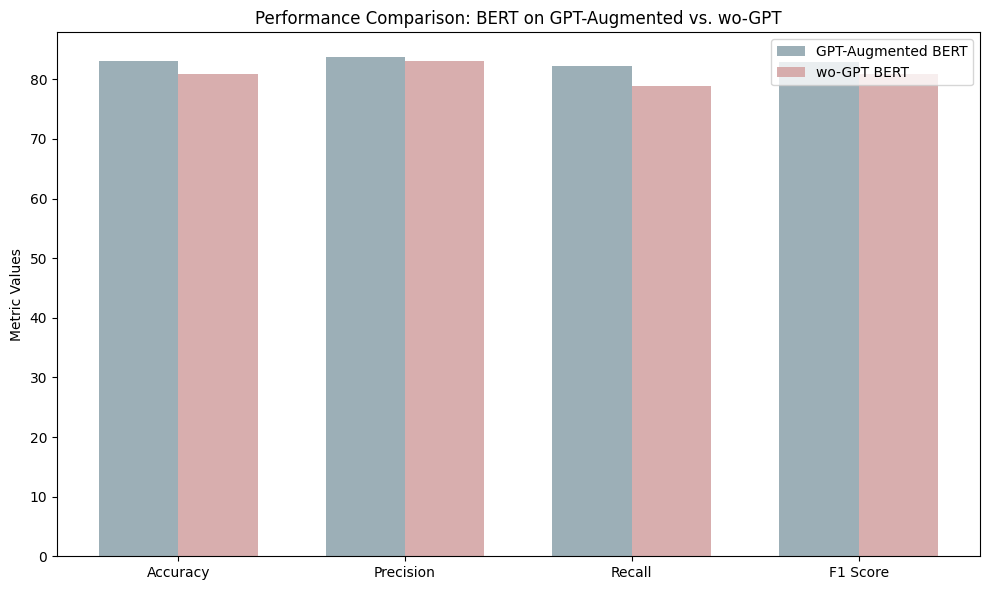

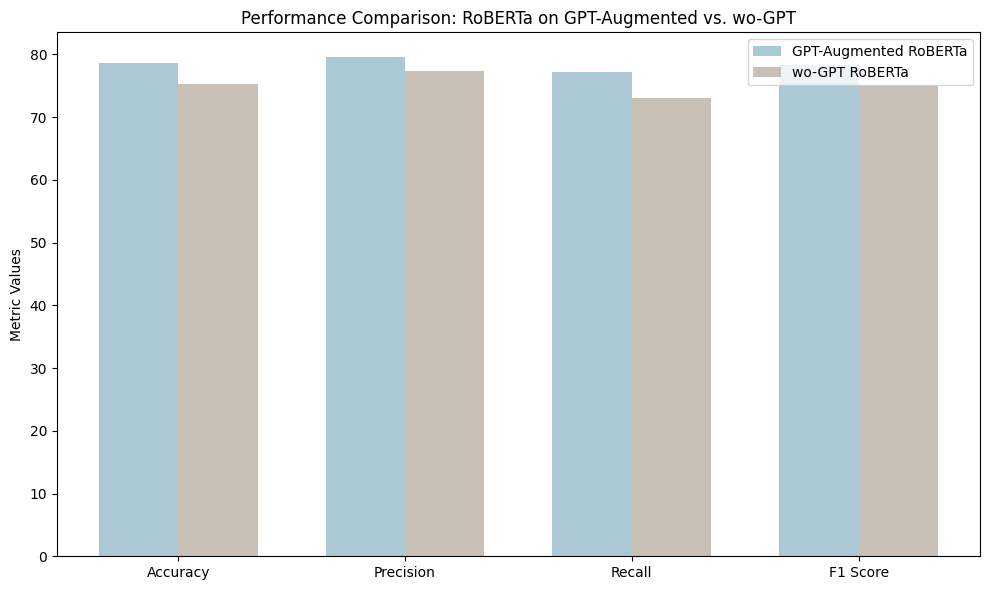

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Data preparation
comparison_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Jokes-GPT-Augmented BERT": [83.08, 83.70, 82.17, 82.93],
    "Jokes-wo-GPT BERT": [80.92, 83.02, 78.83, 80.87],
    "Jokes-GPT-Augmented RoBERTa": [78.67, 79.55, 77.17, 78.34],
    "Jokes-wo-GPT RoBERTa": [75.33, 77.41, 73.13, 75.21]
}

comparison_df = pd.DataFrame(comparison_data)

# Define muted colors
bert_colors = ["#91a6b0", "#d4a5a5"]
roberta_colors = ["#a1c3d1", "#c2b9b0"]

# Plot for BERT
plt.figure(figsize=(10, 6))
x_labels = comparison_data["Metric"]
bar_width = 0.35
x = range(len(x_labels))

# BERT performance plot
plt.bar(
    [p - bar_width / 2 for p in x],
    comparison_data["Jokes-GPT-Augmented BERT"],
    width=bar_width,
    label="GPT-Augmented BERT",
    alpha=0.9,
    color=bert_colors[0]
)
plt.bar(
    [p + bar_width / 2 for p in x],
    comparison_data["Jokes-wo-GPT BERT"],
    width=bar_width,
    label="wo-GPT BERT",
    alpha=0.9,
    color=bert_colors[1]
)

# Add labels and title for BERT
plt.title("Performance Comparison: BERT on GPT-Augmented vs. wo-GPT")
plt.ylabel("Metric Values")
plt.xticks(x, x_labels)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for RoBERTa
plt.figure(figsize=(10, 6))

# RoBERTa performance plot
plt.bar(
    [p - bar_width / 2 for p in x],
    comparison_data["Jokes-GPT-Augmented RoBERTa"],
    width=bar_width,
    label="GPT-Augmented RoBERTa",
    alpha=0.9,
    color=roberta_colors[0]
)
plt.bar(
    [p + bar_width / 2 for p in x],
    comparison_data["Jokes-wo-GPT RoBERTa"],
    width=bar_width,
    label="wo-GPT RoBERTa",
    alpha=0.9,
    color=roberta_colors[1]
)

# Add labels and title for RoBERTa
plt.title("Performance Comparison: RoBERTa on GPT-Augmented vs. wo-GPT")
plt.ylabel("Metric Values")
plt.xticks(x, x_labels)
plt.legend()
plt.tight_layout()
plt.show()
